## Problem Statement


Predict the Remaining Useful Life (RUL) of turbo fan jet engines using multivariate time series data. Given simulated Run-to-Failure data from NASA's C-MAPSS dataset, develop a model that estimates the number of operational cycles remaining for each engine in the test dataset, accounting for various operational settings and sensor noise. The model should help in prognostics and health management by identifying the time left before engine failure, enabling preventative maintenance and reducing downtime.

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split , cross_val_score , RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier

import pickle



In [93]:
index_names = ['Engine', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ["T2", "T24", "T30", "T50", "P2", "P15", "P30", "Nf", "Nc", "epr", 
                "Ps30", "phi", "NRf", "NRc", "BPR", "farB", "htBleed", "Nf_dmd", 
                "PCNfR_dmd", "W31", "W32"]
col_names = index_names + setting_names + sensor_names

In [94]:
raw_data_1 = pd.read_csv(r"C:\MY_FILES\DATA_SCIENCE\ML\Projects\aircraft\CMAPSSData\train_FD001.txt",sep=' ',header=None,index_col=False,names=col_names)
raw_data_2 = pd.read_csv(r"C:\MY_FILES\DATA_SCIENCE\ML\Projects\aircraft\CMAPSSData\train_FD002.txt",sep=' ',header=None,index_col=False,names=col_names)
raw_data_3 = pd.read_csv(r"C:\MY_FILES\DATA_SCIENCE\ML\Projects\aircraft\CMAPSSData\train_FD003.txt",sep=' ',header=None,index_col=False,names=col_names)
raw_data_4 = pd.read_csv(r"C:\MY_FILES\DATA_SCIENCE\ML\Projects\aircraft\CMAPSSData\train_FD004.txt",sep=' ',header=None,index_col=False,names=col_names)


C:\Users\VYSAK\AppData\Local\Temp\ipykernel_1988\2784969793.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  raw_data_1 = pd.read_csv(r"C:\MY_FILES\DATA_SCIENCE\ML\Projects\aircraft\CMAPSSData\train_FD001.txt",sep=' ',header=None,index_col=False,names=col_names)
C:\Users\VYSAK\AppData\Local\Temp\ipykernel_1988\2784969793.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  raw_data_2 = pd.read_csv(r"C:\MY_FILES\DATA_SCIENCE\ML\Projects\aircraft\CMAPSSData\train_FD002.txt",sep=' ',header=None,index_col=False,names=col_names)
C:\Users\VYSAK\AppData\Local\Temp\ipykernel_1988\2784969793.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  raw_data_3 = pd.read_csv(r"C:\MY_FILES\DATA_SCIENCE\ML\Projects\aircraft\CMAPSSData\train_FD003.txt",sep=' ',header=Non

T2 Total temperature at fan inlet °R

T24 Total temperature at LPC outlet °R

T30 Total temperature at HPC outlet °R

T50 Total temperature at LPT outlet °R

P2 Pressure at fan inlet psia

P15 Total pressure in bypass-duct psia

P30 Total pressure at HPC outlet psia

Nf Physical fan speed rpm

Nc Physical core speed rpm

epr Engine pressure ratio (P50/P2) --

Ps30 Static pressure at HPC outlet psia

phi Ratio of fuel flow to Ps30 pps/psi

NRf Corrected fan speed rpm

NRc Corrected core speed rpm

BPR Bypass Ratio --

farB Burner fuel-air ratio --

htBleed Bleed Enthalpy --

Nf_dmd Demanded fan speed rpm

PCNfR_dmd Demanded corrected fan speed rpm

W31 HPT coolant bleed lbm/s

W32 LPT coolant bleed lbm/s

In [95]:
df1 = raw_data_1.copy()
df2 = raw_data_2.copy()
df3 = raw_data_3.copy()
df4 = raw_data_4.copy()

In [96]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)


(20631, 26)
(53759, 26)
(24720, 26)
(61249, 26)


In [97]:
print(df1.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Engine       20631 non-null  int64  
 1   time_cycles  20631 non-null  int64  
 2   setting_1    20631 non-null  float64
 3   setting_2    20631 non-null  float64
 4   setting_3    20631 non-null  float64
 5   T2           20631 non-null  float64
 6   T24          20631 non-null  float64
 7   T30          20631 non-null  float64
 8   T50          20631 non-null  float64
 9   P2           20631 non-null  float64
 10  P15          20631 non-null  float64
 11  P30          20631 non-null  float64
 12  Nf           20631 non-null  float64
 13  Nc           20631 non-null  float64
 14  epr          20631 non-null  float64
 15  Ps30         20631 non-null  float64
 16  phi          20631 non-null  float64
 17  NRf          20631 non-null  float64
 18  NRc          20631 non-null  float64
 19  BPR 

In [98]:
print(df2.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53759 entries, 0 to 53758
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Engine       53759 non-null  int64  
 1   time_cycles  53759 non-null  int64  
 2   setting_1    53759 non-null  float64
 3   setting_2    53759 non-null  float64
 4   setting_3    53759 non-null  float64
 5   T2           53759 non-null  float64
 6   T24          53759 non-null  float64
 7   T30          53759 non-null  float64
 8   T50          53759 non-null  float64
 9   P2           53759 non-null  float64
 10  P15          53759 non-null  float64
 11  P30          53759 non-null  float64
 12  Nf           53759 non-null  float64
 13  Nc           53759 non-null  float64
 14  epr          53759 non-null  float64
 15  Ps30         53759 non-null  float64
 16  phi          53759 non-null  float64
 17  NRf          53759 non-null  float64
 18  NRc          53759 non-null  float64
 19  BPR 

In [99]:
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24720 entries, 0 to 24719
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Engine       24720 non-null  int64  
 1   time_cycles  24720 non-null  int64  
 2   setting_1    24720 non-null  float64
 3   setting_2    24720 non-null  float64
 4   setting_3    24720 non-null  float64
 5   T2           24720 non-null  float64
 6   T24          24720 non-null  float64
 7   T30          24720 non-null  float64
 8   T50          24720 non-null  float64
 9   P2           24720 non-null  float64
 10  P15          24720 non-null  float64
 11  P30          24720 non-null  float64
 12  Nf           24720 non-null  float64
 13  Nc           24720 non-null  float64
 14  epr          24720 non-null  float64
 15  Ps30         24720 non-null  float64
 16  phi          24720 non-null  float64
 17  NRf          24720 non-null  float64
 18  NRc          24720 non-null  float64
 19  BPR 

In [100]:
print(df4.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61249 entries, 0 to 61248
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Engine       61249 non-null  int64  
 1   time_cycles  61249 non-null  int64  
 2   setting_1    61249 non-null  float64
 3   setting_2    61249 non-null  float64
 4   setting_3    61249 non-null  float64
 5   T2           61249 non-null  float64
 6   T24          61249 non-null  float64
 7   T30          61249 non-null  float64
 8   T50          61249 non-null  float64
 9   P2           61249 non-null  float64
 10  P15          61249 non-null  float64
 11  P30          61249 non-null  float64
 12  Nf           61249 non-null  float64
 13  Nc           61249 non-null  float64
 14  epr          61249 non-null  float64
 15  Ps30         61249 non-null  float64
 16  phi          61249 non-null  float64
 17  NRf          61249 non-null  float64
 18  NRc          61249 non-null  float64
 19  BPR 

In [101]:
#create a column End cycle for each engine 

df1['End_cycle'] = df1.groupby('Engine')['time_cycles'].transform('max')
df2['End_cycle'] = df2.groupby('Engine')['time_cycles'].transform('max')
df3['End_cycle'] = df3.groupby('Engine')['time_cycles'].transform('max')
df4['End_cycle'] = df4.groupby('Engine')['time_cycles'].transform('max')


In [102]:
# Calculate "LR"
df1["LR"] = df1.apply(lambda row: row["time_cycles"] / row["End_cycle"], axis=1)
df2["LR"] = df2.apply(lambda row: row["time_cycles"] / row["End_cycle"], axis=1)
df3["LR"] = df3.apply(lambda row: row["time_cycles"] / row["End_cycle"], axis=1)
df4["LR"] = df4.apply(lambda row: row["time_cycles"] / row["End_cycle"], axis=1)

In [103]:
df1

,Engine,time_cycles,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,End_cycle,LR
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,0.005208
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,0.010417
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,0.015625
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,0.020833
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,0.026042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,200,0.980000
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,200,0.985000
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,200,0.990000
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,200,0.995000


In [104]:
# Concatenate all dataframes vertically (row-wise)
df = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)


In [105]:
df

,Engine,time_cycles,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,End_cycle,LR
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,0.005208
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,0.010417
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,0.015625
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,0.020833
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,0.026042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,8185.69,8.4541,0.03,372,2319,100.0,29.11,17.5234,255,0.984314
160355,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,8185.47,8.2221,0.03,396,2388,100.0,39.38,23.7151,255,0.988235
160356,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,8193.94,8.2525,0.03,395,2388,100.0,39.78,23.8270,255,0.992157
160357,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,8125.64,9.0515,0.02,337,2223,100.0,15.26,9.0774,255,0.996078


In [106]:
# Drop Engine and End_cycle
df.drop(columns=['Engine','End_cycle'], inplace = True)



Defining the labels
Here we will define the engine's condition with Life Ratio (LR), which is the ratio between Current Cycle and the End cycle. If LR=0, that means the component has just started its degradation and LR=1 means, it is completely degraded.

if LR <= 0.6 - Good Condition - 0

if 0.6 < LR <= 0.8 - Moderate Condition - 1

if 0.8 < LR - Warning Condition - 2


In [107]:
labels=[]
for i in range (0,len(df)):
    if np.array(df["LR"])[i] <= 0.6:
        labels.append(0)
    elif np.array(df["LR"])[i] <= 0.8 :
        labels.append(1)   
    else :
        labels.append(2)  
        
df["labels"]=labels
df  = df.drop(columns=['LR'])   
df

,time_cycles,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,P15,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,labels
0,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,0
1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0
2,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0
3,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0
4,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,15.46,...,2388.73,8185.69,8.4541,0.03,372,2319,100.0,29.11,17.5234,2
160355,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,21.57,...,2388.46,8185.47,8.2221,0.03,396,2388,100.0,39.38,23.7151,2
160356,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,21.57,...,2388.48,8193.94,8.2525,0.03,395,2388,100.0,39.78,23.8270,2
160357,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,7.96,...,2388.83,8125.64,9.0515,0.02,337,2223,100.0,15.26,9.0774,2


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160359 entries, 0 to 160358
Data columns (total 26 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time_cycles  160359 non-null  int64  
 1   setting_1    160359 non-null  float64
 2   setting_2    160359 non-null  float64
 3   setting_3    160359 non-null  float64
 4   T2           160359 non-null  float64
 5   T24          160359 non-null  float64
 6   T30          160359 non-null  float64
 7   T50          160359 non-null  float64
 8   P2           160359 non-null  float64
 9   P15          160359 non-null  float64
 10  P30          160359 non-null  float64
 11  Nf           160359 non-null  float64
 12  Nc           160359 non-null  float64
 13  epr          160359 non-null  float64
 14  Ps30         160359 non-null  float64
 15  phi          160359 non-null  float64
 16  NRf          160359 non-null  float64
 17  NRc          160359 non-null  float64
 18  BPR          160359 non-

In [109]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
time_cycles,160359.0,123.331338,83.538146,1.0000,57.00000,114.0000,173.0000,543.0000
setting_1,160359.0,17.211973,16.527988,-0.0087,0.00130,19.9981,35.0015,42.0080
setting_2,160359.0,0.410004,0.367938,-0.0006,0.00020,0.6200,0.8400,0.8420
setting_3,160359.0,95.724344,12.359044,60.0000,100.00000,100.0000,100.0000,100.0000
T2,160359.0,485.840890,30.420388,445.0000,449.44000,489.0500,518.6700,518.6700
T24,160359.0,597.361022,42.478516,535.4800,549.96000,605.9300,642.3400,645.1100
T30,160359.0,1467.035653,118.175261,1242.6700,1357.36000,1492.8100,1586.5900,1616.9100
T50,160359.0,1260.956434,136.300073,1023.7700,1126.83000,1271.7400,1402.2000,1441.4900
P2,160359.0,9.894999,4.265554,3.9100,5.48000,9.3500,14.6200,14.6200
P15,160359.0,14.424935,6.443922,5.6700,8.00000,13.6600,21.6100,21.6100


In [110]:
# farB (Burner fuel-air ratio) value varies less than 0.02 which will not effect the label since its a minute change, so droping it 
df.drop(columns = 'farB', inplace = True)

In [111]:
df.isna().sum()

time_cycles    0
setting_1      0
setting_2      0
setting_3      0
T2             0
T24            0
T30            0
T50            0
P2             0
P15            0
P30            0
Nf             0
Nc             0
epr            0
Ps30           0
phi            0
NRf            0
NRc            0
BPR            0
htBleed        0
Nf_dmd         0
PCNfR_dmd      0
W31            0
W32            0
labels         0
dtype: int64

In [112]:
df.duplicated().sum()

0

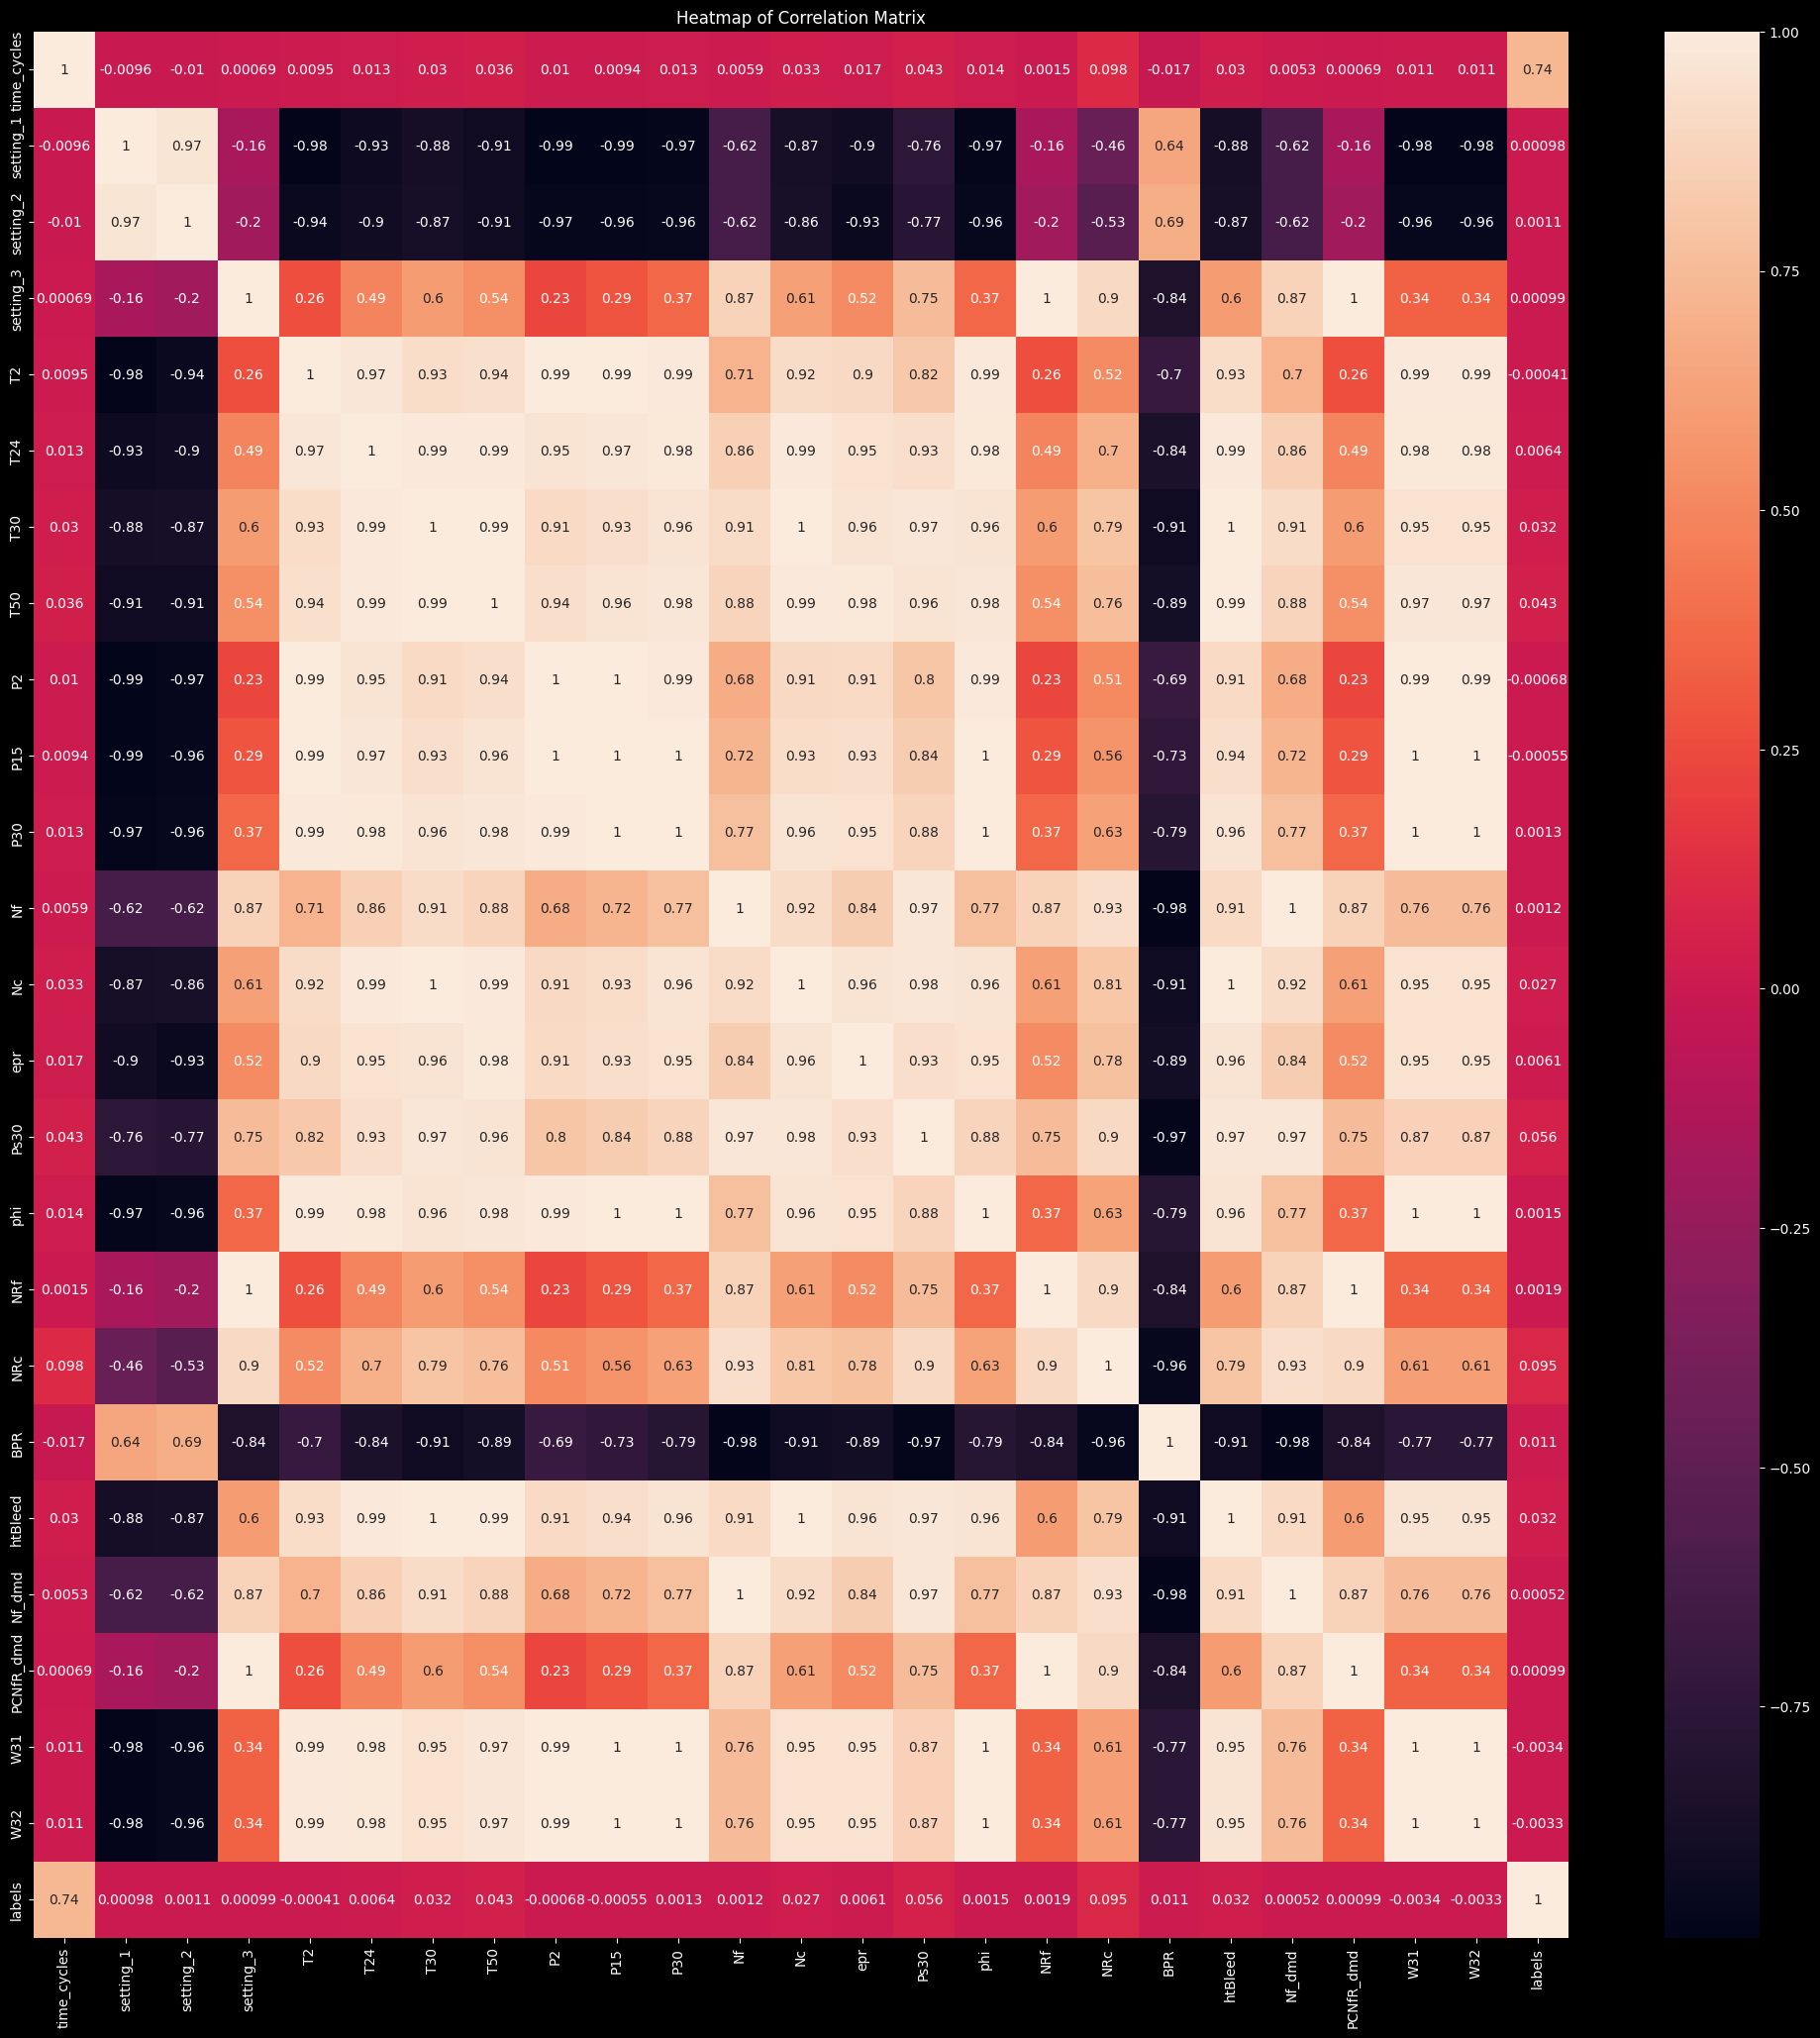

In [113]:
plt.figure(figsize=(25, 25))  
sns.heatmap(df.corr(), annot=True)  
plt.title("Heatmap of Correlation Matrix")
plt.show()

In [114]:
df['setting_3'].value_counts()

setting_3
100.0    143218
60.0      17141
Name: count, dtype: int64

In [115]:
df['NRf'].value_counts()

NRf
2388.09    5257
2388.10    5232
2388.07    5205
2388.08    5143
2388.11    5031
           ... 
2027.66       1
2027.65       1
2029.80       1
2030.18       1
2030.13       1
Name: count, Length: 567, dtype: int64

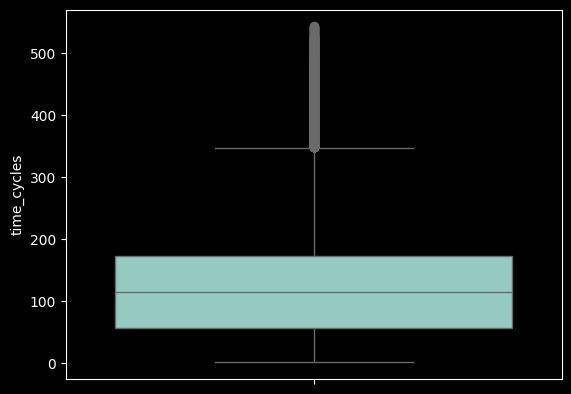

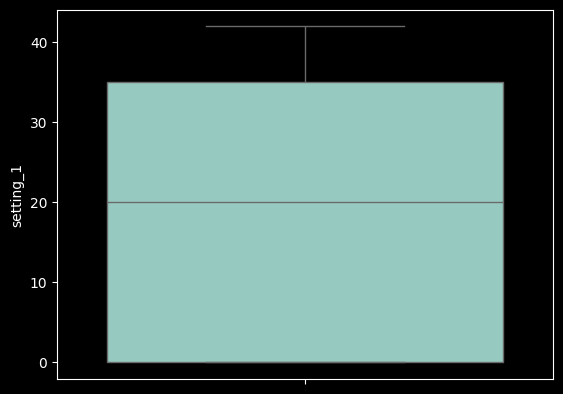

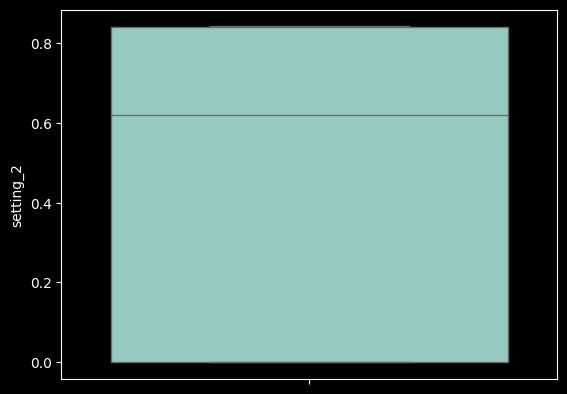

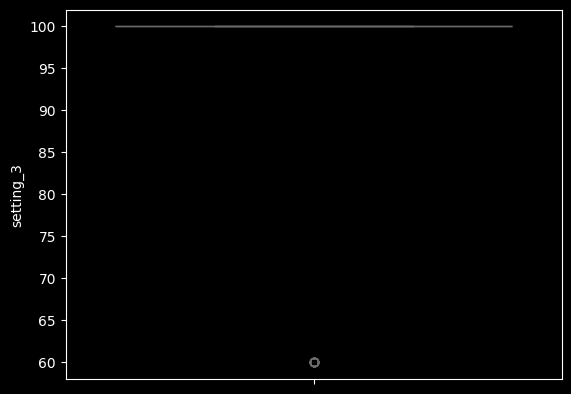

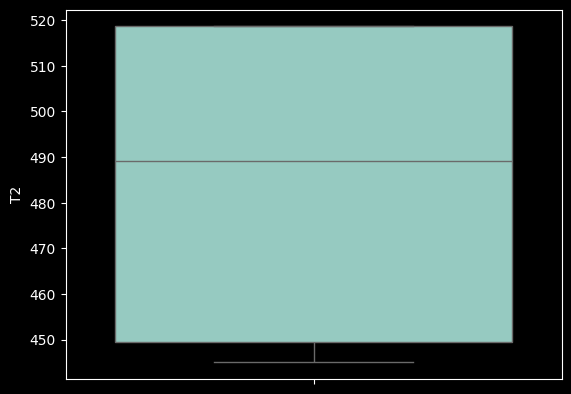

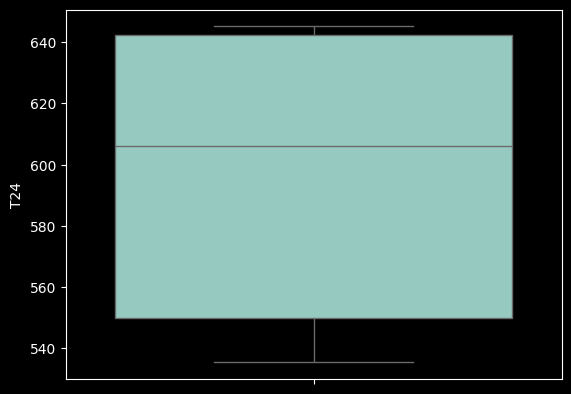

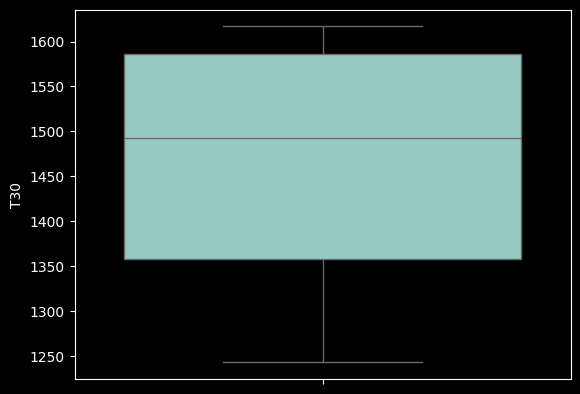

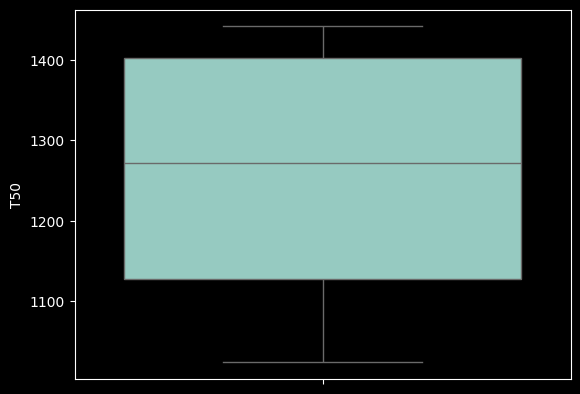

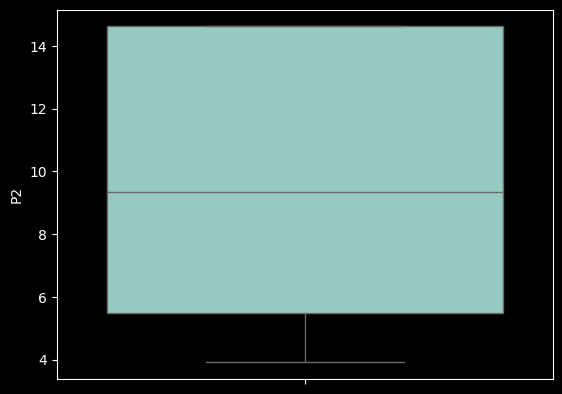

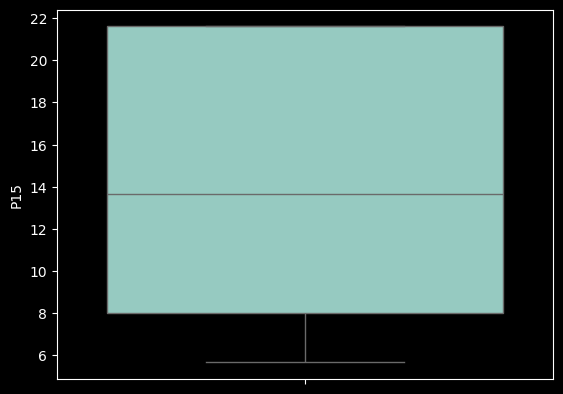

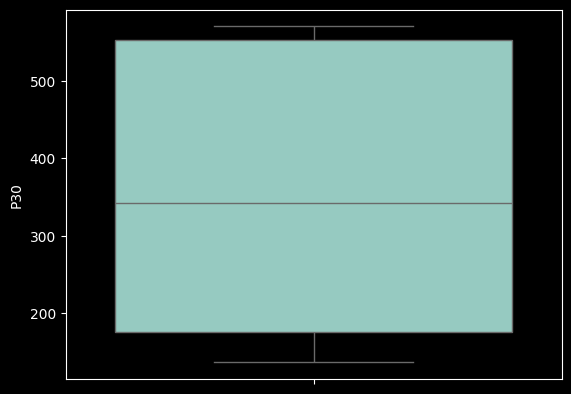

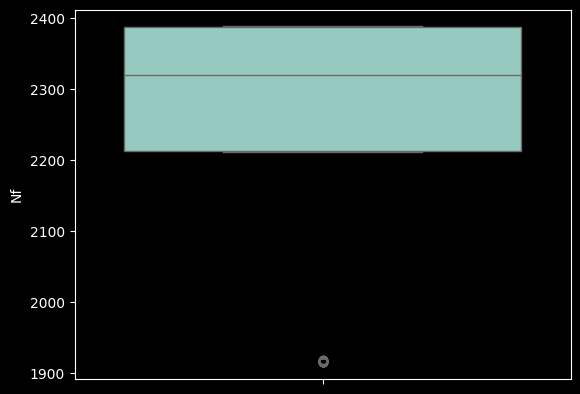

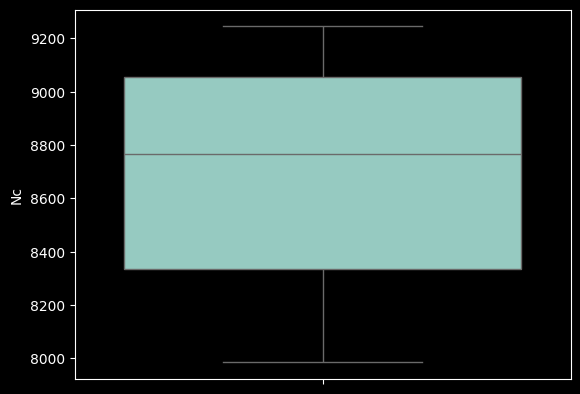

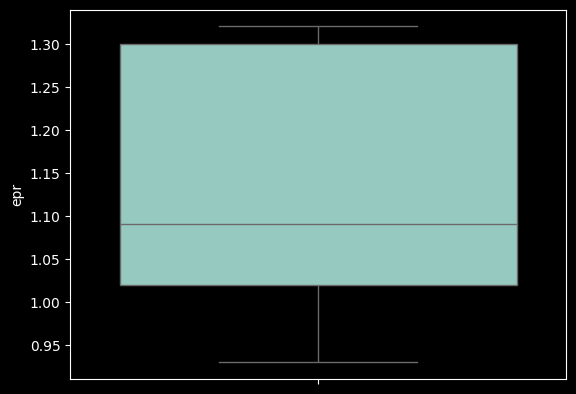

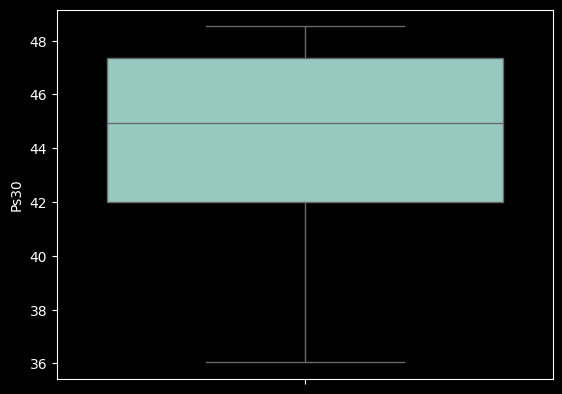

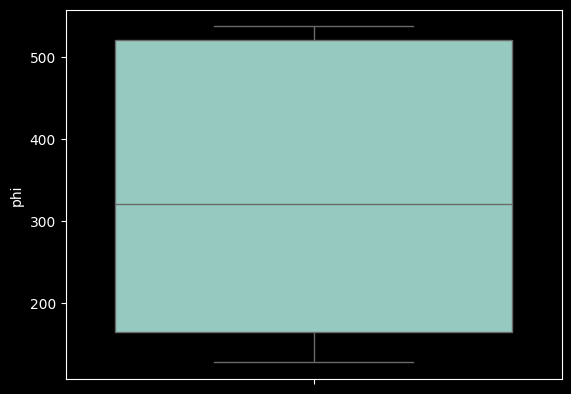

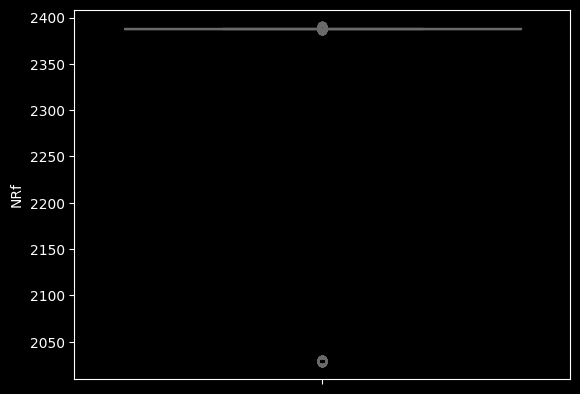

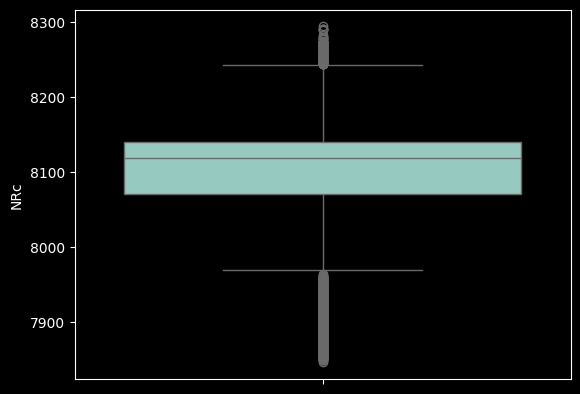

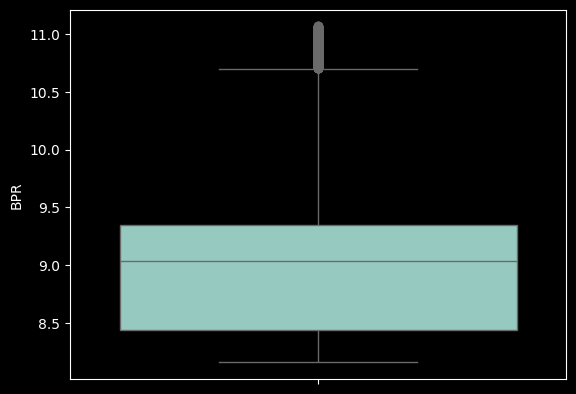

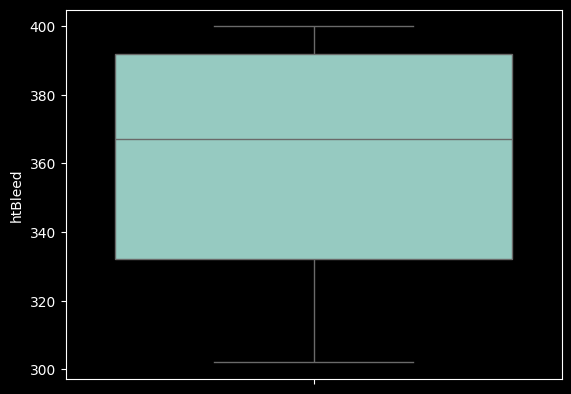

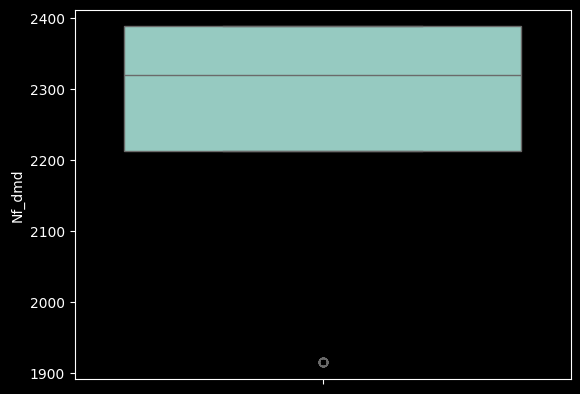

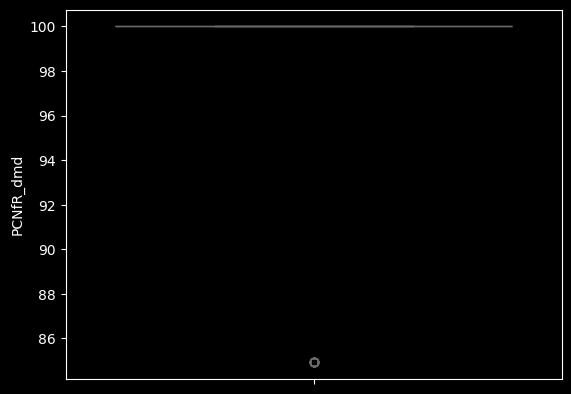

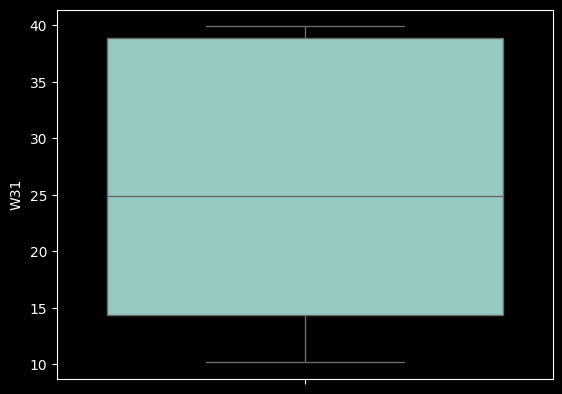

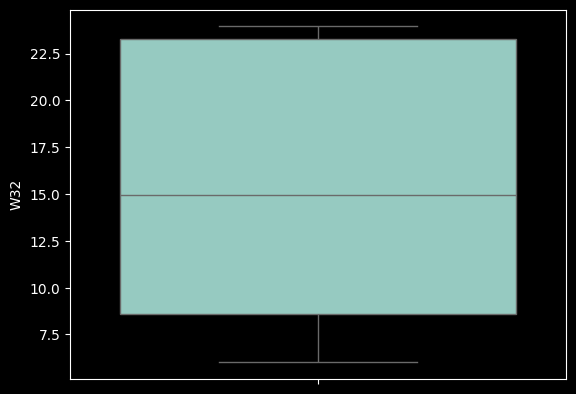

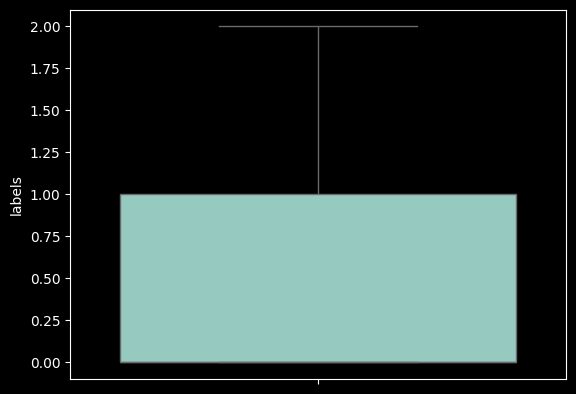

In [116]:
for i in df.columns:
    sns.boxplot(y=df[f"{i}"]) 
    plt.show()

In [120]:
df.columns

Index(['time_cycles', 'setting_1', 'setting_2', 'setting_3', 'T2', 'T24',
       'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi',
       'NRf', 'NRc', 'BPR', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32',
       'labels'],
      dtype='object')

In [121]:
outliers_cols = ['setting_3','PCNfR_dmd','Nf_dmd','BPR','NRc','NRf','Nf']
for col in outliers_cols:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  min_range = Q1 - 1.5 * IQR
  max_range = Q3 + 1.5 * IQR
  df = df[(df[col] >= min_range) & (df[col] <= max_range)]

In [122]:
df.shape

(131082, 25)

In [123]:
df['labels'].value_counts()

labels
0    82894
1    27168
2    21020
Name: count, dtype: int64

## Splitting

In [129]:
x = df.drop(columns='labels')
y = df['labels']

## Train Test Split

In [130]:
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=0.3,random_state=42)

## Scaling 

In [131]:
minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_test = minmax.transform(x_test)
x_scaled = minmax.fit_transform(x)

## Model Building

In [132]:
models = [
    {
        'name': 'KNN',
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': range(1,32,2),'weights': ['uniform', 'distance'],'p': [1, 2]},
        'scores':{},
        'scores_list':[],
        'avg':0
    },
    {
        'name': 'SVM',
        'model': SVC(),
        'params': {'C': [0.1, 1, 10, 100],'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],},
        'scores':{},
        'scores_list':[],
        'avg':0
    },
    {
        'name': 'Naive bayes',
        'model': GaussianNB(),
        'params': {},
        'scores':{},
        'scores_list':[],
        'avg':0
    },
    {
        'name': 'Decision Tree',
        'model': DecisionTreeClassifier(),
        'params':{'criterion':['gini','entropy'],'max_depth':[i for i in range(10,150,10)],'min_samples_split':list(range(10,50,5))},
        'scores':{},
        'scores_list':[],
        'avg':0
    },
    {

        'name': 'Random Forest',
        'model': RandomForestClassifier(),
        'params':{'criterion':['gini','entropy'],'max_depth':[i for i in range(10,150,10)],'min_samples_split':list(range(10,50,5))},
        'scores':{},
        'scores_list':[],
        'avg':0
  },
    {
        'name': 'Gradient Boosting',
        'model': GradientBoostingClassifier(),
        'params': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]},
        'scores':{},
        'scores_list':[],
        'avg':0
    },
    {
        'name': 'XGBoost',
        'model': XGBClassifier(),
        'params': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2],
                   'max_depth': [3, 4, 5]},
        'scores':{},
        'scores_list':[],
        'avg':0
    }
]

## Model evaluation

In [133]:
for i in models:
  i['model'].fit(x_train,y_train)
  y_pred = i['model'].predict(x_test)
  print(i['name'])
  print(accuracy_score(y_test,y_pred))
  print(confusion_matrix(y_test,y_pred))
  print(classification_report(y_test,y_pred))
  print()


KNN
0.867844882390337
[[23316  1506    25]
 [ 1870  5506   791]
 [   48   957  5306]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     24847
           1       0.69      0.67      0.68      8167
           2       0.87      0.84      0.85      6311

    accuracy                           0.87     39325
   macro avg       0.83      0.82      0.82     39325
weighted avg       0.87      0.87      0.87     39325


SVM
0.870184361093452
[[23536  1303     8]
 [ 1939  5504   724]
 [   16  1115  5180]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     24847
           1       0.69      0.67      0.68      8167
           2       0.88      0.82      0.85      6311

    accuracy                           0.87     39325
   macro avg       0.83      0.81      0.82     39325
weighted avg       0.87      0.87      0.87     39325


Naive bayes
0.6052892561983471
[[17964   413  6470]
 [ 2239  136

## Cross validation

In [135]:
scoring=['accuracy','precision_macro','recall_macro','f1_macro']

for i in models:
  for j in scoring:
    scores = cross_val_score(i['model'],x_scaled,y,cv=5, scoring=j)
    score = {j: round(scores.mean(), 2)}
    i['scores_list'].append(scores.mean())
    i['scores'].update(score)
  i['avg']=sum(i['scores_list'])/len(i['scores_list'])

best_alg = max(models, key=lambda x: x['avg'])

KeyboardInterrupt: 

In [ ]:
for i in models:
  print(f"{i['name']}: {i['scores']}")

print()
for i in models:
  print(f"{i['name']}: {i['avg']}")

print(f"\nBest Model: {best_alg['name']}")

## Hyper parameter tuning 

In [ ]:
random= RandomizedSearchCV(best_alg['model'],best_alg['params'],cv=5)
random.fit(x_scaled,y)

In [ ]:
random.best_params_

In [ ]:
random.best_score_

## Best Model

In [ ]:
best_model = random.best_estimator_

## Pickle file creation

final_model = {'model':best_model,'scaler':minmax}

In [ ]:
filename = 'JetEngineConditionPredictionModel.pkl'

# Save the model
with open(filename, 'wb') as file:
    pickle.dump(final_model, file)

In [ ]:
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)
    model = loaded_model['model']
    scaler = loaded_model['scaler']

In [ ]:
x.columns